Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [5]:
pickle_file = 'notMNIST_200k.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [6]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [7]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Tune L2 regularization for logistic model

In [8]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases) 
  # Add the regularization term to the loss.
  loss += 5e-4 * regularizers
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [9]:
num_steps = 30001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  lossVec = []
  trainAcc = []
  validAcc = []
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    lossVec.append(l)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      
      trainAcc.append(accuracy(predictions, batch_labels))
      validAcc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 19.274778
Minibatch loss at step 100: 3.159260
Minibatch loss at step 200: 3.174854
Minibatch loss at step 300: 2.899036
Minibatch loss at step 400: 2.838298
Minibatch loss at step 500: 2.099874
Minibatch loss at step 600: 2.393768
Minibatch loss at step 700: 2.265441
Minibatch loss at step 800: 1.670291
Minibatch loss at step 900: 1.835260
Minibatch loss at step 1000: 1.813816
Minibatch loss at step 1100: 1.802212
Minibatch loss at step 1200: 1.460770
Minibatch loss at step 1300: 1.606140
Minibatch loss at step 1400: 1.346922
Minibatch loss at step 1500: 1.028840
Minibatch loss at step 1600: 1.411310
Minibatch loss at step 1700: 1.183965
Minibatch loss at step 1800: 1.403946
Minibatch loss at step 1900: 1.379503
Minibatch loss at step 2000: 0.977990
Minibatch loss at step 2100: 1.030939
Minibatch loss at step 2200: 1.168305
Minibatch loss at step 2300: 1.238066
Minibatch loss at step 2400: 0.896950
Minibatch loss at step 2500: 1.008323
Minibatch l

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(lossVec)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

plt.clf()
plt.plot(xrange(0,3001,100),trainAcc, label= "Minibatch Accuracy")
plt.plot(xrange(0,3001,100),validAcc, label= "Valid Accuracy")
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.show()


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Tune L2 regularization for neural network model

In [10]:
batch_size = 128
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weightsHidden = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biasesHidden = tf.Variable(tf.zeros([hidden_layer_size]))
    
  weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  logitsHidden = tf.matmul(tf_train_dataset, weightsHidden) + biasesHidden
  hiddenLayer = tf.nn.relu(logitsHidden)

  # Training computation.
  logits = tf.matmul(hiddenLayer, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weightsHidden) + tf.nn.l2_loss(biasesHidden) +
                  tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))
  # Add the regularization term to the loss.
  loss += 5e-4 * regularizers
 
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden) + biasesHidden)
  valid_logits = tf.matmul(valid_hidden, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden) + biasesHidden)
  test_logits = tf.matmul(test_hidden, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [11]:
num_steps = 30001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  lossVec = []
  trainAcc = []
  validAcc = []
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    lossVec.append(l)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      
      trainAcc.append(accuracy(predictions, batch_labels))
      validAcc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 492.566711
Minibatch loss at step 100: 164.932800
Minibatch loss at step 200: 179.862656
Minibatch loss at step 300: 152.022263
Minibatch loss at step 400: 146.356796
Minibatch loss at step 500: 133.668655
Minibatch loss at step 600: 121.251968
Minibatch loss at step 700: 130.789398
Minibatch loss at step 800: 107.102165
Minibatch loss at step 900: 101.696976
Minibatch loss at step 1000: 100.344101
Minibatch loss at step 1100: 91.339127
Minibatch loss at step 1200: 86.512970
Minibatch loss at step 1300: 82.582367
Minibatch loss at step 1400: 77.761520
Minibatch loss at step 1500: 74.231133
Minibatch loss at step 1600: 70.891693
Minibatch loss at step 1700: 65.501678
Minibatch loss at step 1800: 63.426483
Minibatch loss at step 1900: 62.126720
Minibatch loss at step 2000: 57.097679
Minibatch loss at step 2100: 53.752029
Minibatch loss at step 2200: 52.936195
Minibatch loss at step 2300: 50.468494
Minibatch loss at step 2400: 47.995010
Minibatch loss

In [12]:
fName = 'Experiment_2.pickle'

try:
  f = open(fName, 'wb')
  save = {
    'lossVec': lossVec,
    'trainAcc': trainAcc,
    'validAcc': validAcc,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
pickle_file = 'Experiment_2.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  lossVec = save['lossVec']
  trainAcc = save['trainAcc']
  validAcc = save['validAcc']
  del save  # hint to help gc free up memory

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


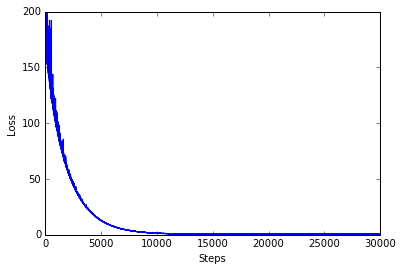

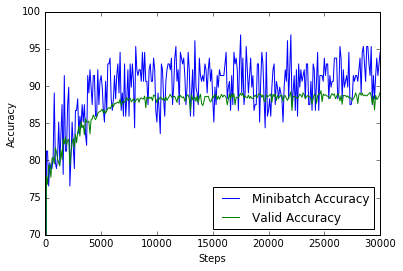

In [14]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()
plt.plot(lossVec)
plt.xlabel('Steps')
plt.ylabel('Loss')
axes = plt.gca()
axes.set_ylim([0,200])
plt.show()

plt.clf()
plt.plot(xrange(0,30001,100),trainAcc, label= "Minibatch Accuracy")
plt.plot(xrange(0,30001,100),validAcc, label= "Valid Accuracy")
axes = plt.gca()
axes.set_ylim([70,100])
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.savefig('Experiment_2.png')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [6]:
batch_size = 12

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 18.152536
Minibatch accuracy: 8.3%
Validation accuracy: 10.8%
Minibatch loss at step 500: 1.933836
Minibatch accuracy: 91.7%
Validation accuracy: 72.1%
Minibatch loss at step 1000: 0.268556
Minibatch accuracy: 91.7%
Validation accuracy: 69.4%
Minibatch loss at step 1500: 0.018284
Minibatch accuracy: 100.0%
Validation accuracy: 75.6%
Minibatch loss at step 2000: 4.813074
Minibatch accuracy: 75.0%
Validation accuracy: 73.0%
Minibatch loss at step 2500: 2.566367
Minibatch accuracy: 75.0%
Validation accuracy: 73.6%
Minibatch loss at step 3000: 2.651227
Minibatch accuracy: 83.3%
Validation accuracy: 75.3%
Test accuracy: 83.0%


In [8]:
batch_size = 12
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weightsHidden = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biasesHidden = tf.Variable(tf.zeros([hidden_layer_size]))
  
  logitsHidden = tf.matmul(tf_train_dataset, weightsHidden) + biasesHidden
  hiddenLayer = tf.nn.relu(logitsHidden)

  weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))

  # Training computation.
  logits = tf.matmul(hiddenLayer, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
 
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden) + biasesHidden)
  valid_logits = tf.matmul(valid_hidden, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden) + biasesHidden)
  test_logits = tf.matmul(test_hidden, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [9]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 343.291992
Minibatch accuracy: 0.0%
Validation accuracy: 12.5%
Minibatch loss at step 500: 403.188721
Minibatch accuracy: 75.0%
Validation accuracy: 57.8%
Minibatch loss at step 1000: 22.845827
Minibatch accuracy: 58.3%
Validation accuracy: 54.3%
Minibatch loss at step 1500: 44.549931
Minibatch accuracy: 75.0%
Validation accuracy: 56.5%
Minibatch loss at step 2000: 3119.778076
Minibatch accuracy: 66.7%
Validation accuracy: 57.9%
Minibatch loss at step 2500: 99.572533
Minibatch accuracy: 41.7%
Validation accuracy: 58.1%
Minibatch loss at step 3000: 239.537170
Minibatch accuracy: 66.7%
Validation accuracy: 56.3%
Test accuracy: 61.8%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [15]:
batch_size = 128
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weightsHidden = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biasesHidden = tf.Variable(tf.zeros([hidden_layer_size]))
  
  logitsHidden = tf.matmul(tf_train_dataset, weightsHidden) + biasesHidden
  hiddenLayer = tf.nn.relu(logitsHidden)

  # Add a 50% dropout during training only. Dropout also scales
  # activations such that no rescaling is needed at evaluation time.
  hidden = tf.nn.dropout(hiddenLayer, 0.5, seed=None)

  weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits = tf.matmul(hidden, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weightsHidden) + tf.nn.l2_loss(biasesHidden) +
                  tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))
  # Add the regularization term to the loss.
  loss += 5e-4 * regularizers
 
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden) + biasesHidden)
  valid_logits = tf.matmul(valid_hidden, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden) + biasesHidden)
  test_logits = tf.matmul(test_hidden, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [16]:
num_steps = 30001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  lossVec = []
  trainAcc = []
  validAcc = []
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    lossVec.append(l)
    if (step % 100 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      #print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      #print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      
      trainAcc.append(accuracy(predictions, batch_labels))
      validAcc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 621.514160
Minibatch loss at step 100: 194.757156
Minibatch loss at step 200: 229.357498
Minibatch loss at step 300: 156.935684
Minibatch loss at step 400: 163.726089
Minibatch loss at step 500: 152.150177
Minibatch loss at step 600: 137.132690
Minibatch loss at step 700: 139.579590
Minibatch loss at step 800: 113.138260
Minibatch loss at step 900: 108.688881
Minibatch loss at step 1000: 103.073929
Minibatch loss at step 1100: 98.588264
Minibatch loss at step 1200: 90.997398
Minibatch loss at step 1300: 89.865631
Minibatch loss at step 1400: 82.991379
Minibatch loss at step 1500: 80.852081
Minibatch loss at step 1600: 75.868774
Minibatch loss at step 1700: 67.112907
Minibatch loss at step 1800: 65.067574
Minibatch loss at step 1900: 64.487663
Minibatch loss at step 2000: 57.981853
Minibatch loss at step 2100: 55.510502
Minibatch loss at step 2200: 53.671085
Minibatch loss at step 2300: 52.946709
Minibatch loss at step 2400: 48.430599
Minibatch loss

In [17]:
fName = 'Experiment_3.pickle'

try:
  f = open(fName, 'wb')
  save = {
    'lossVec': lossVec,
    'trainAcc': trainAcc,
    'validAcc': validAcc,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [18]:
pickle_file = 'Experiment_3.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  lossVec = save['lossVec']
  trainAcc = save['trainAcc']
  validAcc = save['validAcc']
  del save  # hint to help gc free up memory

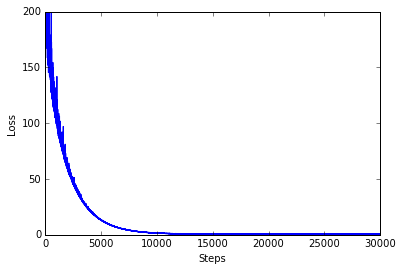

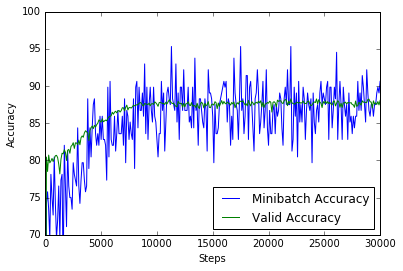

In [19]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()
plt.plot(lossVec)
plt.xlabel('Steps')
plt.ylabel('Loss')
axes = plt.gca()
axes.set_ylim([0,200])
plt.show()

plt.clf()
plt.plot(xrange(0,30001,100),trainAcc, label= "Minibatch Accuracy")
plt.plot(xrange(0,30001,100),validAcc, label= "Valid Accuracy")
axes = plt.gca()
axes.set_ylim([70,100])
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.savefig('Experiment_3.png')
plt.show()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


# Use learning rate decay:

In [10]:
batch_size = 128
hidden_layer_size = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weightsHidden = tf.Variable(tf.truncated_normal([image_size * image_size, hidden_layer_size]))
  biasesHidden = tf.Variable(tf.zeros([hidden_layer_size]))
  
  logitsHidden = tf.matmul(tf_train_dataset, weightsHidden) + biasesHidden
  hiddenLayer = tf.nn.relu(logitsHidden)



  # Add a 50% dropout during training only. Dropout also scales
  # activations such that no rescaling is needed at evaluation time.
  hidden = tf.nn.dropout(hiddenLayer, 0.5)

  weights = tf.Variable(tf.truncated_normal([hidden_layer_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))  
  
  # Training computation.
  logits = tf.matmul(hidden, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weightsHidden) + tf.nn.l2_loss(biasesHidden) +
                  tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))
  # Add the regularization term to the loss.
  loss += 5e-4 * regularizers
 
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1, 0.9999)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden) + biasesHidden)
  valid_logits = tf.matmul(valid_hidden, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden) + biasesHidden)
  test_logits = tf.matmul(test_hidden, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [11]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 586.644470
Minibatch accuracy: 10.9%
Validation accuracy: 31.1%
Minibatch loss at step 500: 144.450104
Minibatch accuracy: 80.5%
Validation accuracy: 80.9%
Minibatch loss at step 1000: 108.369019
Minibatch accuracy: 71.9%
Validation accuracy: 80.5%
Minibatch loss at step 1500: 81.405472
Minibatch accuracy: 77.3%
Validation accuracy: 80.9%
Minibatch loss at step 2000: 64.280525
Minibatch accuracy: 78.9%
Validation accuracy: 81.8%
Minibatch loss at step 2500: 52.148396
Minibatch accuracy: 78.1%
Validation accuracy: 82.5%
Minibatch loss at step 3000: 42.689499
Minibatch accuracy: 79.7%
Validation accuracy: 83.1%
Minibatch loss at step 3500: 36.635384
Minibatch accuracy: 82.0%
Validation accuracy: 82.6%
Minibatch loss at step 4000: 30.571907
Minibatch accuracy: 82.0%
Validation accuracy: 83.9%
Minibatch loss at step 4500: 25.554876
Minibatch accuracy: 80.5%
Validation accuracy: 84.0%
Minibatch loss at step 5000: 22.136137
Minibatch accuracy: 85.9%
Vali

# Deeper Network along with learning rate decay:

# First try: 2 relu hidden layers with 1024 nodes. Use dropout 50%. Use learning rate decay. 

In [12]:
import math as math
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden Layer 1, 1024 nodes
  weightsHidden1 = tf.Variable(tf.truncated_normal([image_size * image_size, 1024], stddev=math.sqrt(2.0/1024)))
  biasesHidden1 = tf.Variable(tf.zeros([1024]))
  logitsHidden1 = tf.matmul(tf_train_dataset, weightsHidden1) + biasesHidden1
  hiddenLayer1 = tf.nn.relu(logitsHidden1)

  # Hidden Layer 2, 1024 nodes
  weightsHidden2 = tf.Variable(tf.truncated_normal([1024, 1024], stddev=math.sqrt(2.0/1024)))
  biasesHidden2 = tf.Variable(tf.zeros([1024]))
  logitsHidden2 = tf.matmul(hiddenLayer1, weightsHidden2) + biasesHidden2
  hiddenLayer2 = tf.nn.relu(logitsHidden2)


  # Add a 50% dropout during training only. Dropout also scales
  # activations such that no rescaling is needed at evaluation time.
  hidden = tf.nn.dropout(hiddenLayer2, 0.5)

  # Training computation.
  weights = tf.Variable(tf.truncated_normal([1024, num_labels], stddev=math.sqrt(2.0/1024)))
  biases = tf.Variable(tf.zeros([num_labels]))  
  logits = tf.matmul(hidden, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weightsHidden1) + tf.nn.l2_loss(biasesHidden1) +
                  tf.nn.l2_loss(weightsHidden2) + tf.nn.l2_loss(biasesHidden2) +
                  tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))
  # Add the regularization term to the loss.
  loss += 5e-4 * regularizers
 
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1, 0.9999)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden1) + biasesHidden1)
  valid_hidden2 = tf.nn.relu(tf.matmul(valid_hidden1, weightsHidden2) + biasesHidden2)
  valid_logits = tf.matmul(valid_hidden2, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden1) + biasesHidden1)
  test_hidden2 = tf.nn.relu(tf.matmul(test_hidden1, weightsHidden2) + biasesHidden2)
  test_logits = tf.matmul(test_hidden2, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [13]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Final Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.139753
Minibatch accuracy: 9.4%
Validation accuracy: 34.0%
Minibatch loss at step 500: 0.939973
Minibatch accuracy: 89.1%
Validation accuracy: 85.8%
Minibatch loss at step 1000: 0.942260
Minibatch accuracy: 86.7%
Validation accuracy: 86.7%
Minibatch loss at step 1500: 0.681094
Minibatch accuracy: 91.4%
Validation accuracy: 87.6%
Minibatch loss at step 2000: 0.626840
Minibatch accuracy: 92.2%
Validation accuracy: 88.2%
Minibatch loss at step 2500: 0.630180
Minibatch accuracy: 90.6%
Validation accuracy: 88.1%
Minibatch loss at step 3000: 0.622546
Minibatch accuracy: 89.8%
Validation accuracy: 88.5%
Minibatch loss at step 3500: 0.644756
Minibatch accuracy: 88.3%
Validation accuracy: 88.5%
Minibatch loss at step 4000: 0.517130
Minibatch accuracy: 92.2%
Validation accuracy: 89.1%
Minibatch loss at step 4500: 0.456688
Minibatch accuracy: 91.4%
Validation accuracy: 88.8%
Minibatch loss at step 5000: 0.518913
Minibatch accuracy: 91.4%
Validation accuracy

# Second try:

In [14]:
import math as math
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden Layer 1, 1024 nodes
  h1_size = 1024
  weightsHidden1 = tf.Variable(tf.truncated_normal([image_size * image_size, h1_size], stddev=math.sqrt(2.0/(image_size * image_size))))
  biasesHidden1 = tf.Variable(tf.zeros([h1_size]))
  logitsHidden1 = tf.matmul(tf_train_dataset, weightsHidden1) + biasesHidden1
  hiddenLayer1 = tf.nn.relu(logitsHidden1)

  # Hidden Layer 2, 1024 nodes
  h2_size = 1024
  weightsHidden2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=math.sqrt(2.0/h1_size)))
  biasesHidden2 = tf.Variable(tf.zeros([h2_size]))
  logitsHidden2 = tf.matmul(hiddenLayer1, weightsHidden2) + biasesHidden2
  hiddenLayer2 = tf.nn.relu(logitsHidden2)

  # Hidden Layer 3, 305 nodes
  h3_size = 305
  weightsHidden3 = tf.Variable(tf.truncated_normal([h2_size, h3_size], stddev=math.sqrt(2.0/h2_size)))
  biasesHidden3 = tf.Variable(tf.zeros([h3_size]))
  logitsHidden3 = tf.matmul(hiddenLayer2, weightsHidden3) + biasesHidden3
  hiddenLayer3 = tf.nn.relu(logitsHidden3)
    
  # Hidden Layer 4, 75 nodes
  h4_size = 75
  weightsHidden4 = tf.Variable(tf.truncated_normal([h3_size, h4_size], stddev=math.sqrt(2.0/h3_size)))
  biasesHidden4 = tf.Variable(tf.zeros([h4_size]))
  logitsHidden4 = tf.matmul(hiddenLayer3, weightsHidden4) + biasesHidden4
  hiddenLayer4 = tf.nn.relu(logitsHidden4)


  # Add a 50% dropout during training only. Dropout also scales
  # activations such that no rescaling is needed at evaluation time.
  hidden = tf.nn.dropout(hiddenLayer4, 0.5)

  # Training computation.
  weights = tf.Variable(tf.truncated_normal([h4_size, num_labels], stddev=math.sqrt(2.0/h4_size)))
  biases = tf.Variable(tf.zeros([num_labels]))  
  logits = tf.matmul(hidden, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weightsHidden1) + tf.nn.l2_loss(biasesHidden1) +
                  tf.nn.l2_loss(weightsHidden2) + tf.nn.l2_loss(biasesHidden2) +
                  tf.nn.l2_loss(weightsHidden3) + tf.nn.l2_loss(biasesHidden3) +
                  tf.nn.l2_loss(weightsHidden4) + tf.nn.l2_loss(biasesHidden4) +
                  tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))
  # Add the regularization term to the loss.
  loss += 1e-5 * regularizers
 
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1, 0.9999)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden1) + biasesHidden1)
  valid_hidden2 = tf.nn.relu(tf.matmul(valid_hidden1, weightsHidden2) + biasesHidden2)
  valid_hidden3 = tf.nn.relu(tf.matmul(valid_hidden2, weightsHidden3) + biasesHidden3)
  valid_hidden4 = tf.nn.relu(tf.matmul(valid_hidden3, weightsHidden4) + biasesHidden4)
  valid_logits = tf.matmul(valid_hidden4, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden1) + biasesHidden1)
  test_hidden2 = tf.nn.relu(tf.matmul(test_hidden1, weightsHidden2) + biasesHidden2)
  test_hidden3 = tf.nn.relu(tf.matmul(test_hidden2, weightsHidden3) + biasesHidden3)
  test_hidden4 = tf.nn.relu(tf.matmul(test_hidden3, weightsHidden4) + biasesHidden4)
  test_logits = tf.matmul(test_hidden4, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [15]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Final Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.353669
Minibatch accuracy: 8.6%
Validation accuracy: 18.8%
Minibatch loss at step 500: 0.418373
Minibatch accuracy: 85.9%
Validation accuracy: 85.2%
Minibatch loss at step 1000: 0.519943
Minibatch accuracy: 85.2%
Validation accuracy: 86.9%
Minibatch loss at step 1500: 0.363477
Minibatch accuracy: 89.1%
Validation accuracy: 87.6%
Minibatch loss at step 2000: 0.284200
Minibatch accuracy: 93.8%
Validation accuracy: 88.3%
Minibatch loss at step 2500: 0.345797
Minibatch accuracy: 90.6%
Validation accuracy: 88.2%
Minibatch loss at step 3000: 0.385284
Minibatch accuracy: 87.5%
Validation accuracy: 89.2%
Minibatch loss at step 3500: 0.403226
Minibatch accuracy: 87.5%
Validation accuracy: 89.2%
Minibatch loss at step 4000: 0.322997
Minibatch accuracy: 92.2%
Validation accuracy: 89.3%
Minibatch loss at step 4500: 0.278545
Minibatch accuracy: 91.4%
Validation accuracy: 89.2%
Minibatch loss at step 5000: 0.316277
Minibatch accuracy: 91.4%
Validation accuracy

# Third try:

In [22]:
import math as math
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Hidden Layer 1, 2048 nodes
  h1_size = 2048
  weightsHidden1 = tf.Variable(tf.truncated_normal([image_size * image_size, h1_size], stddev=math.sqrt(2.0/(image_size * image_size))))
  biasesHidden1 = tf.Variable(tf.zeros([h1_size]))
  logitsHidden1 = tf.matmul(tf_train_dataset, weightsHidden1) + biasesHidden1
  hiddenLayer1 = tf.nn.relu(logitsHidden1)

  # Hidden Layer 2, 1024 nodes
  h2_size = 1024
  weightsHidden2 = tf.Variable(tf.truncated_normal([h1_size, h2_size], stddev=math.sqrt(2.0/h1_size)))
  biasesHidden2 = tf.Variable(tf.zeros([h2_size]))
  logitsHidden2 = tf.matmul(hiddenLayer1, weightsHidden2) + biasesHidden2
  hiddenLayer2 = tf.nn.relu(logitsHidden2)

  # Hidden Layer 3, 1024 nodes
  h3_size = 1024
  weightsHidden3 = tf.Variable(tf.truncated_normal([h2_size, h3_size], stddev=math.sqrt(2.0/h2_size)))
  biasesHidden3 = tf.Variable(tf.zeros([h3_size]))
  logitsHidden3 = tf.matmul(hiddenLayer2, weightsHidden3) + biasesHidden3
  hiddenLayer3 = tf.nn.relu(logitsHidden3)
    
  # Hidden Layer 4, 1024 nodes
  h4_size = 1024
  weightsHidden4 = tf.Variable(tf.truncated_normal([h3_size, h4_size], stddev=math.sqrt(2.0/h3_size)))
  biasesHidden4 = tf.Variable(tf.zeros([h4_size]))
  logitsHidden4 = tf.matmul(hiddenLayer3, weightsHidden4) + biasesHidden4
  hiddenLayer4 = tf.nn.relu(logitsHidden4)

  # Add a 50% dropout during training only. Dropout also scales
  # activations such that no rescaling is needed at evaluation time.
  hidden = tf.nn.dropout(hiddenLayer4, 0.5)

  # Training computation.
  weights = tf.Variable(tf.truncated_normal([h4_size, num_labels], stddev=math.sqrt(2.0/h4_size)))
  biases = tf.Variable(tf.zeros([num_labels]))  
  logits = tf.matmul(hidden, weights) + biases
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # L2 regularization for the fully connected parameters.
  regularizers = (tf.nn.l2_loss(weightsHidden1) + tf.nn.l2_loss(biasesHidden1) +
                  tf.nn.l2_loss(weightsHidden2) + tf.nn.l2_loss(biasesHidden2) +
                  tf.nn.l2_loss(weightsHidden3) + tf.nn.l2_loss(biasesHidden3) +
                  tf.nn.l2_loss(weightsHidden4) + tf.nn.l2_loss(biasesHidden4) +
                  tf.nn.l2_loss(weights) + tf.nn.l2_loss(biases))
  # Add the regularization term to the loss.
  loss += 1e-5 * regularizers
 
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.95)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  #optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_hidden1 = tf.nn.relu(tf.matmul(tf_valid_dataset, weightsHidden1) + biasesHidden1)
  valid_hidden2 = tf.nn.relu(tf.matmul(valid_hidden1, weightsHidden2) + biasesHidden2)
  valid_hidden3 = tf.nn.relu(tf.matmul(valid_hidden2, weightsHidden3) + biasesHidden3)
  valid_hidden4 = tf.nn.relu(tf.matmul(valid_hidden3, weightsHidden4) + biasesHidden4)
  valid_logits = tf.matmul(valid_hidden4, weights) + biases
  valid_prediction = tf.nn.softmax(valid_logits)
    
  test_hidden1 = tf.nn.relu(tf.matmul(tf_test_dataset, weightsHidden1) + biasesHidden1)
  test_hidden2 = tf.nn.relu(tf.matmul(test_hidden1, weightsHidden2) + biasesHidden2)
  test_hidden3 = tf.nn.relu(tf.matmul(test_hidden2, weightsHidden3) + biasesHidden3)
  test_hidden4 = tf.nn.relu(tf.matmul(test_hidden3, weightsHidden4) + biasesHidden4)
  test_logits = tf.matmul(test_hidden4, weights) + biases
  test_prediction = tf.nn.softmax(test_logits)

In [23]:
num_steps = 30001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  lossVec = []
  trainAcc = []
  validAcc = []
  lrVec = []
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, lr, predictions = session.run([optimizer, loss, learning_rate, train_prediction], feed_dict=feed_dict)
    lossVec.append(l)
    lrVec.append(lr)
    if (step % 200 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch learning rate at step %d: %f" % (step, lr))
      trainAcc.append(accuracy(predictions, batch_labels))
      validAcc.append(accuracy(valid_prediction.eval(), valid_labels))
  print("Final Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.436976
Minibatch learning rate at step 0: 0.500000
Minibatch loss at step 200: 0.587807
Minibatch learning rate at step 200: 0.494897
Minibatch loss at step 400: 0.510476
Minibatch learning rate at step 400: 0.489846
Minibatch loss at step 600: 0.567313
Minibatch learning rate at step 600: 0.484846
Minibatch loss at step 800: 0.383878
Minibatch learning rate at step 800: 0.479898
Minibatch loss at step 1000: 0.513349
Minibatch learning rate at step 1000: 0.475000
Minibatch loss at step 1200: 0.369692
Minibatch learning rate at step 1200: 0.470152
Minibatch loss at step 1400: 0.368005
Minibatch learning rate at step 1400: 0.465354
Minibatch loss at step 1600: 0.437011
Minibatch learning rate at step 1600: 0.460604
Minibatch loss at step 1800: 0.402134
Minibatch learning rate at step 1800: 0.455903
Minibatch loss at step 2000: 0.260245
Minibatch learning rate at step 2000: 0.451250
Minibatch loss at step 2200: 0.391105
Minibatch learning rate at st

In [24]:
fName = 'Experiment_4.pickle'

try:
  f = open(fName, 'wb')
  save = {
    'lossVec': lossVec,
    'trainAcc': trainAcc,
    'validAcc': validAcc,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [25]:
pickle_file = 'Experiment_4.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  lossVec = save['lossVec']
  trainAcc = save['trainAcc']
  validAcc = save['validAcc']
  del save  # hint to help gc free up memory

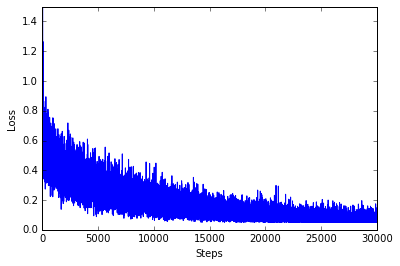

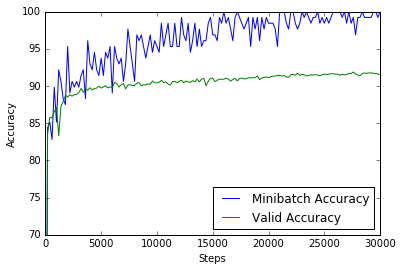

In [29]:
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt

plt.clf()
plt.plot(lossVec)
plt.xlabel('Steps')
plt.ylabel('Loss')
axes = plt.gca()
axes.set_ylim([0,1.5])
plt.show()

plt.clf()
plt.plot(xrange(0,30001,200),trainAcc, label= "Minibatch Accuracy")
plt.plot(xrange(0,30001,200),validAcc, label= "Valid Accuracy")
axes = plt.gca()
axes.set_ylim([70,100])
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend(loc=4)
#plt.savefig('Experiment_1.png')
plt.show()
